# Просто логическая регрессия


In [4]:
# импортируем нужные библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api

У нас есть такие данные:

1.   gender - пол
2.   read, write, maths - количественно оцененные активности
3.   hon - окончание с красным дипломом(Y)/без него(N)




In [5]:
df = pd.read_csv('/data_of_learning.csv',sep=';')
print(df.head())

  gender  read  write  math hon
0   male    57     52    41   N
1   male    44     33    54   N
2   male    63     44    47   N
3   male    47     52    57   N
4   male    50     59    42   N


Мы хотим узнать с какой вероятностью мы получим красный диплом или нет, в зависимости от переменных gender, read, math

Для начала определим базовую категорию - ту вер-ть, которую будем предсказывать (Y, т е с какой вероятность получим диплом)

In [6]:
#делаем переменную категориальной
df['hon'] = df['hon'].astype('category')
#задаем порядок категорий (первая станет базовой)
df['hon'] = df['hon'].cat.reorder_categories(['Y', 'N'], ordered=True)


Создадим модель логистической регрессии и обучим ее с помощью метода fit

In [7]:
model = smf.glm(formula='hon ~ read + math + gender', data=df, family=statsmodels.api.families.Binomial()).fit()
print(model.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['hon[Y]', 'hon[N]']   No. Observations:                  150
Model:                              GLM   Df Residuals:                      146
Model Family:                  Binomial   Df Model:                            3
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -54.874
Date:                  Sun, 26 Jan 2025   Deviance:                       109.75
Time:                          13:22:04   Pearson chi2:                     121.
No. Iterations:                       6   Pseudo R-squ. (CS):             0.2988
Covariance Type:              nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -12.124

Коэфиценты для каждой переменной обозначают ln(odds) <=> logit(p), ведь

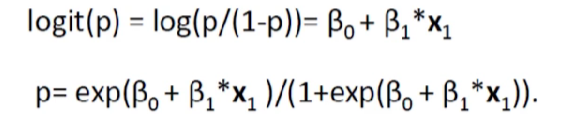

здесь log - это типо ln

По идее мы сейчас имеем вот такое равенство logit(p) = ln(1/1-p) = 12 - 0.06 *
read - 0.14 * math + 1.2 * gender


Выражаем отсюда p и получаем p = exp(12 - 0.06 * read - 0.14 * math + 1.2 * gender) / (1 + exp(12 - 0.06 * read - 0.14 * math + 1.2 * gender))

Но в statsmodels есть метод predict, который на основе логита уже считает вероятность и все это в ручную делать не надо

In [8]:
# по каждой строке данных из df посчитали вероятность получить красный диплом
probabilities = model.predict(df)
print(probabilities)

0      0.021835
1      0.054046
2      0.071285
3      0.095797
4      0.015820
         ...   
145    0.028047
146    0.227952
147    0.403472
148    0.404801
149    0.754392
Length: 150, dtype: float64


Добавим в датафрейм столбец с вероятностями для каждого получить диплом

In [9]:
df['probabilities'] = probabilities
print(df)

     gender  read  write  math hon  probabilities
0      male    57     52    41   N       0.021835
1      male    44     33    54   N       0.054046
2      male    63     44    47   N       0.071285
3      male    47     52    57   N       0.095797
4      male    50     59    42   N       0.015820
..      ...   ...    ...   ...  ..            ...
145  female    41     59    42   N       0.028047
146  female    55     59    52   N       0.227952
147  female    57     41    57   N       0.403472
148  female    55     62    58   Y       0.404801
149  female    63     65    65   Y       0.754392

[150 rows x 6 columns]


# Выбор подходящего порога вероятностей

In [10]:
#импортируем доп библиотеки
from sklearn.metrics import roc_curve, auc

Нам надо построить ROC-кривую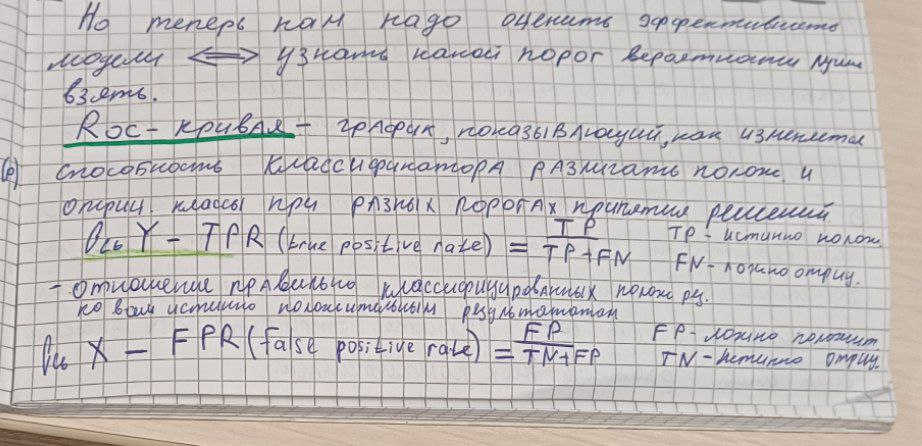

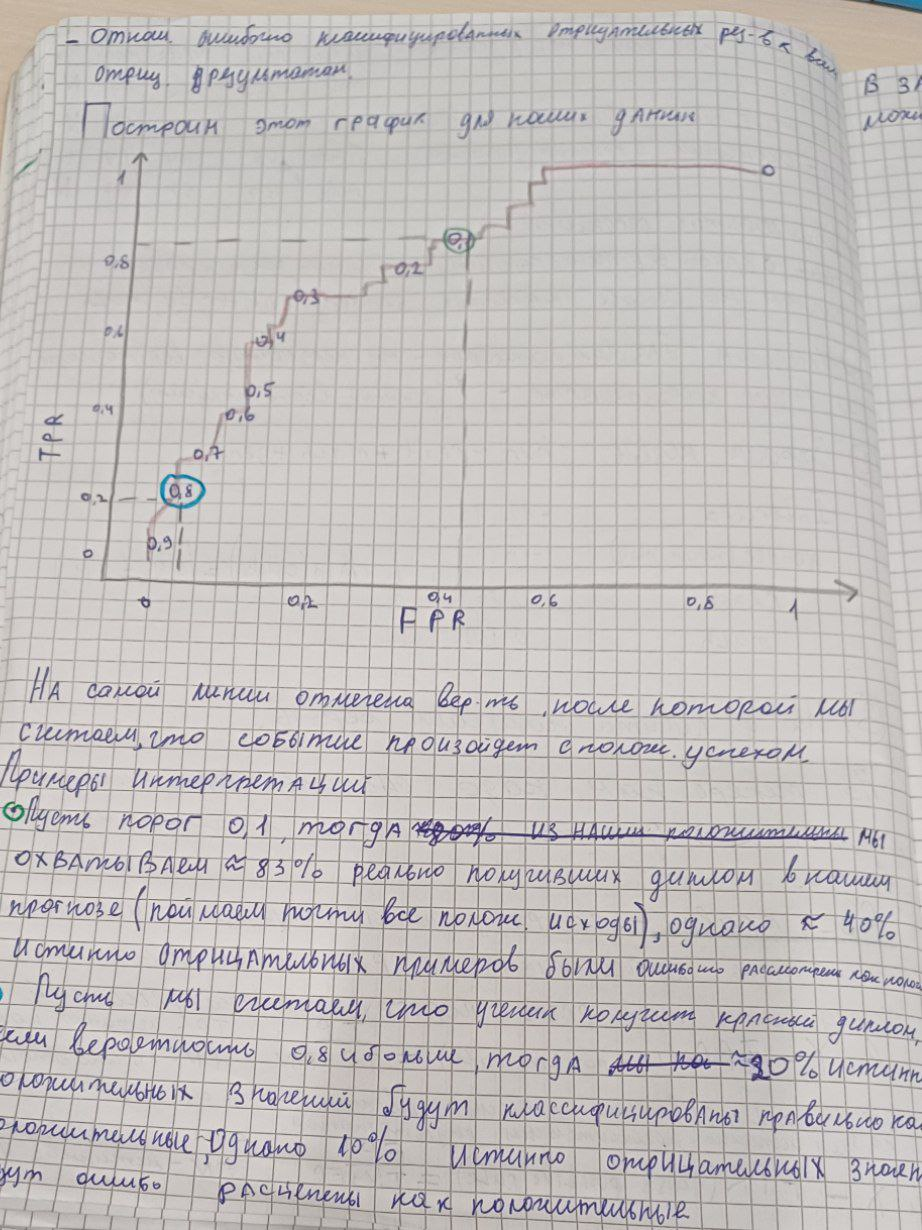

In [11]:
# Вычисление значений для ROC-кривой
fpr, tpr, thresholds = roc_curve(df['hon'], df['probabilities'], pos_label='Y')

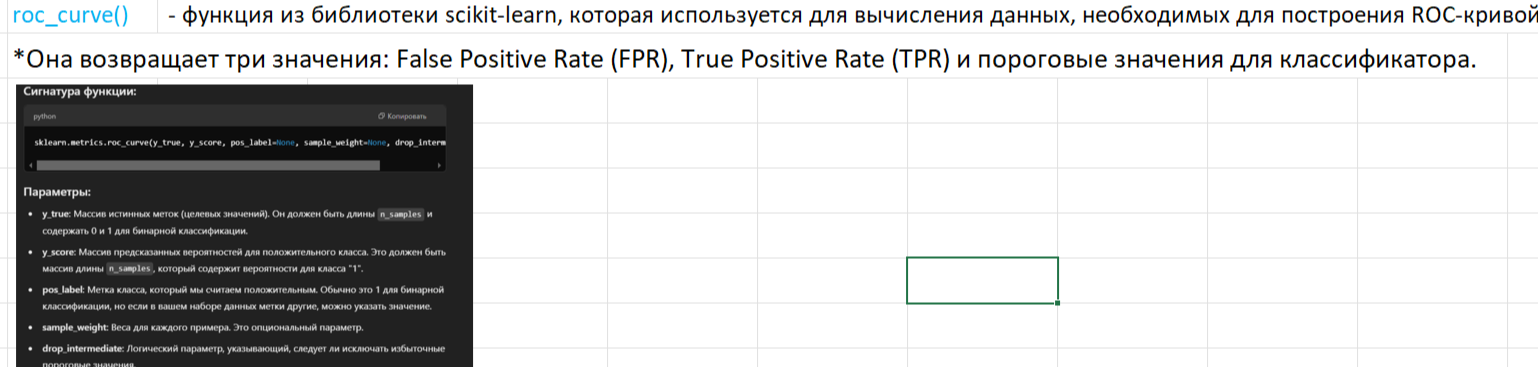

по факту мы получили 3 массива одинакового размера, где каждому i-му индексу соответсвтует  свой fpr, tpr и  thresholds

<ipython-input-12-27ccf1e91932>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


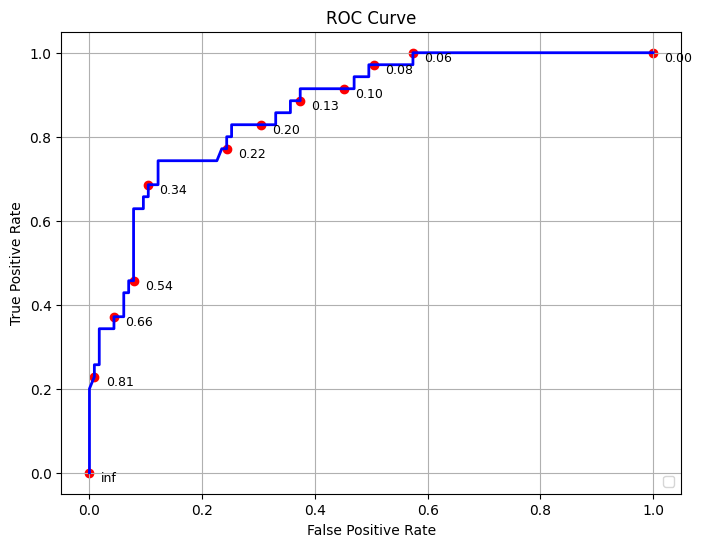

In [12]:
########### Построение ROC-кривой###########
plt.figure(figsize=(8, 6))
# основной график(синяя линия)
plt.plot(fpr, tpr, color='b', lw=2)
# Отметка порогов на графике
for i in range(0, len(fpr), int(len(fpr) / 10)):  # Оставим 10 точек красных на графике и подпишем где какой порог
    plt.scatter(fpr[i], tpr[i], color='red')
    plt.text(fpr[i] + 0.02, tpr[i] - 0.02, f'{thresholds[i]:.2f}', fontsize=9)

# Подпишем оси
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Оценим эффективность модели, рассчитав плошадь под ROC-кривой

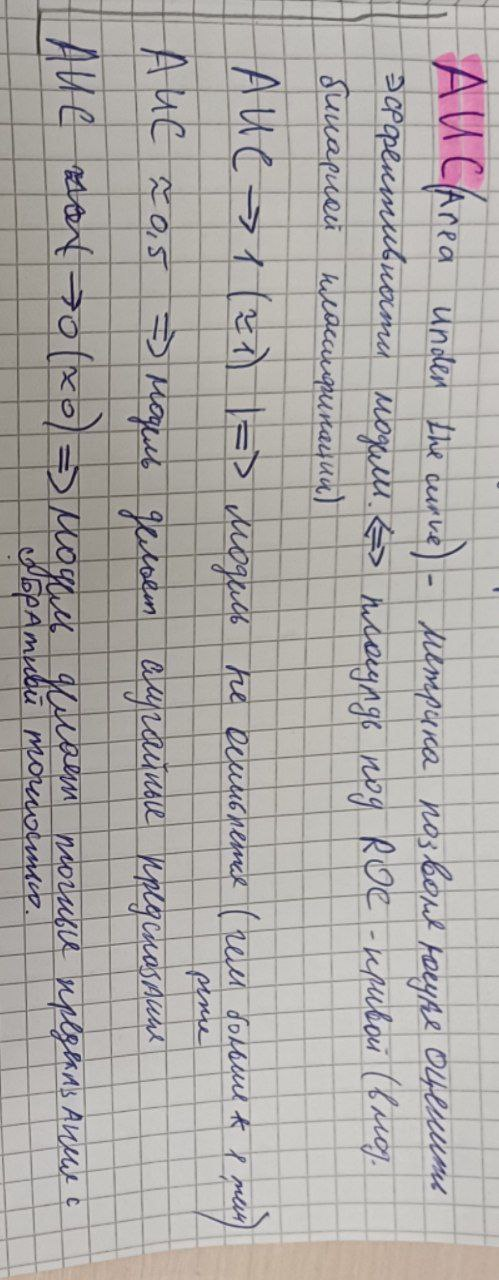

In [13]:
#area under the curve
my_auc = auc(fpr, tpr)
print(my_auc)

0.8703105590062111


Нам надо выбрать , какую вероятность взять в качестве порога

Для начала построим зависимость специфичности (отношения отрицательно оцененных объектов ко всем истинно отрицательным) от порога

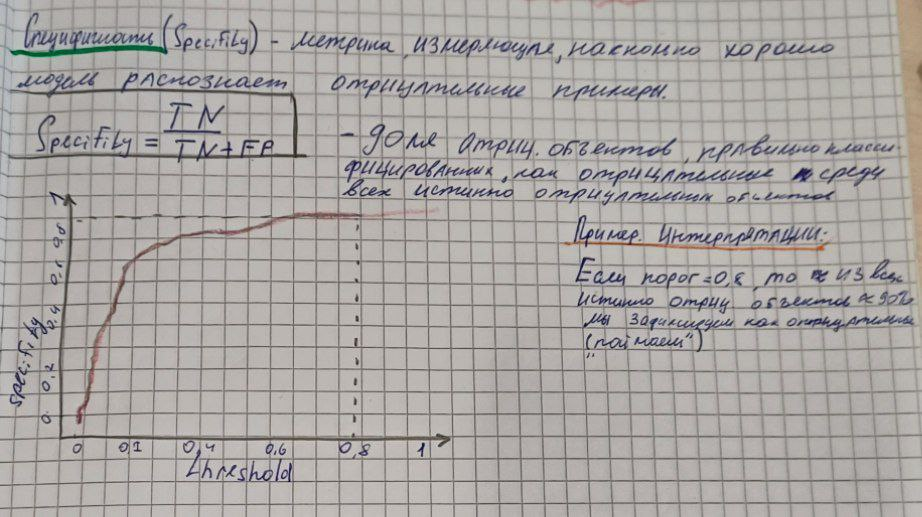

In [14]:
# выгружаем функцию для получения занчений tn, fp, fn, tp
from sklearn.metrics import confusion_matrix
# Инициализируем список для хранения значений специфичности
specificities = []

# Перебираем пороги от 0 до 1 с шагом 0.01
for threshold in np.arange(0.0, 1.0, 0.01):
    # Преобразуем вероятности в бинарные метки с текущим порогом
    y_pred = (df['probabilities']>= threshold).astype(int)
    binary_sp = []
    for i in df['hon'].to_numpy():
        if i == 'Y':
            binary_sp.append(1)
        else:
            binary_sp.append(0)

    # Вычисляем матрицу ошибок
    tn, fp, fn, tp = confusion_matrix(binary_sp, y_pred).ravel()

    # Рассчитываем специфичность
    specificity = tn / (tn + fp)
    specificities.append(specificity)

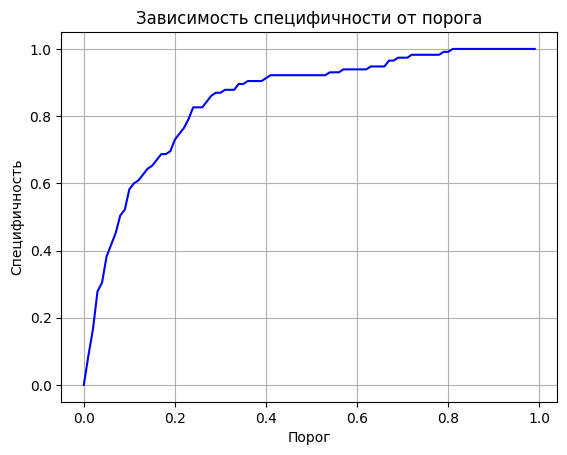

In [15]:
#строим график зависимость специфичности от порога
plt.plot(np.arange(0.0, 1.0, 0.01), specificities, color='blue')
plt.title('Зависимость специфичности от порога')
plt.xlabel('Порог')
plt.ylabel('Специфичность')
plt.grid(True)
plt.show()

Теперь в тех же осях отразим еще и чувствительность (TPR), которая зависит от порога

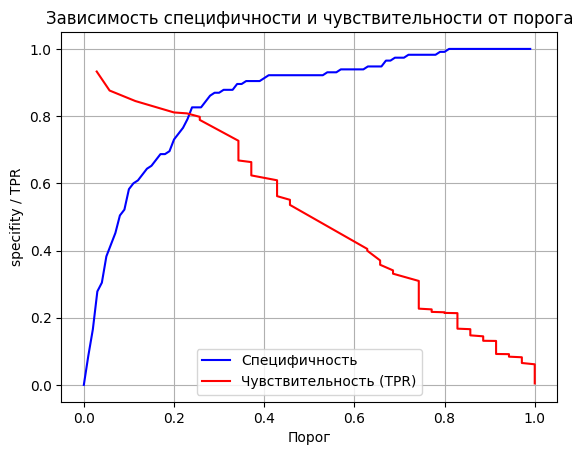

In [16]:
plt.plot(np.arange(0.0, 1.0, 0.01), specificities, color='blue', label='Специфичность')
plt.plot(tpr, thresholds, color='red', label='Чувствительность (TPR)')
plt.title('Зависимость специфичности и чувствительности от порога')
plt.xlabel('Порог')
plt.ylabel('specifity / TPR')
plt.grid(True)
plt.legend()
plt.show()


Заметим что эти графики пересекаются при пороге = 0.25. Значит при таком пороге спицифичность ( доля 'пойманных' отрицательных объектов) равна чувствительности ( доле правильно 'пойманных' положительных объектов), что может служить хорошим ориентиром для установлениям порога.

Однако важно понимать, что в задачах, где важно добиться равного внимания к положительным и отрицательным примерам, эта точка может быть использована как ориентир для выбора порога. Но не каждая задача является такой

Создадим еще один столбец, в котором мы уже конкретно даем прогноз, будет или нет красный диплом. Даем его на основе вероятностей и терпимости к ошибками. В данном случаем мы решили что для нас нет приоритета в чувствительности(ложноположительности) и специфичности(ложноотрицательности)

In [17]:
sp_of_predictions = []
for i in df['probabilities'].to_numpy():
    if i > 0.25:
        sp_of_predictions.append('Y')
    else:
        sp_of_predictions.append('N')
df['my_prediction'] = sp_of_predictions

print(df)


     gender  read  write  math hon  probabilities my_prediction
0      male    57     52    41   N       0.021835             N
1      male    44     33    54   N       0.054046             N
2      male    63     44    47   N       0.071285             N
3      male    47     52    57   N       0.095797             N
4      male    50     59    42   N       0.015820             N
..      ...   ...    ...   ...  ..            ...           ...
145  female    41     59    42   N       0.028047             N
146  female    55     59    52   N       0.227952             N
147  female    57     41    57   N       0.403472             Y
148  female    55     62    58   Y       0.404801             Y
149  female    63     65    65   Y       0.754392             Y

[150 rows x 7 columns]


# Дополнительная оценка эффектинвости модели

Для начала создадим новый столбец, который указывает, правильно ли на самом деле мы предсказали значения

In [18]:
df['rightness'] = df['my_prediction'] == df['hon']

print(df)


     gender  read  write  math hon  probabilities my_prediction  rightness
0      male    57     52    41   N       0.021835             N       True
1      male    44     33    54   N       0.054046             N       True
2      male    63     44    47   N       0.071285             N       True
3      male    47     52    57   N       0.095797             N       True
4      male    50     59    42   N       0.015820             N       True
..      ...   ...    ...   ...  ..            ...           ...        ...
145  female    41     59    42   N       0.028047             N       True
146  female    55     59    52   N       0.227952             N       True
147  female    57     41    57   N       0.403472             Y      False
148  female    55     62    58   Y       0.404801             Y       True
149  female    63     65    65   Y       0.754392             Y       True

[150 rows x 8 columns]


Построим гафик, отражающий то, насколько часто мы предсказываем правильно

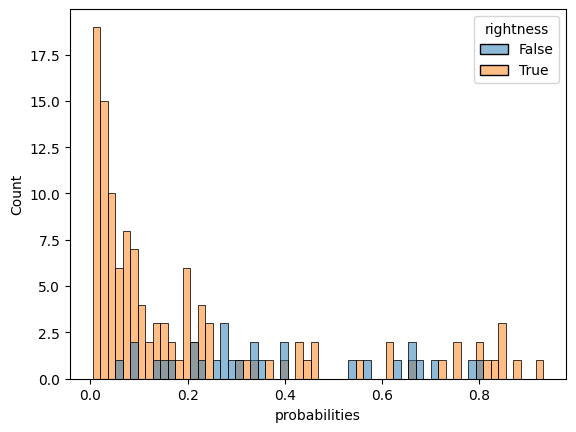

In [19]:
sns.histplot(data=df, x='probabilities', hue='rightness', bins=60)
plt.show()

Заметим, что предсказать, что человек не получит красный диплом  ( вероятность около 0) получается лучше чем предсказать, что он получит его.

Найдем сколько в среднем правильных прогнозов мы даем

In [20]:
# это то же самое что мы разделили кол - во всех значенй на кол-во тех, где True
avg = np.mean(df['rightness'])
print(avg)

0.8066666666666666
